In [126]:
%pylab inline
%load_ext autoreload
%autoreload 2
# nicer plots, but only available in recent matplotlib
try:
    plt.style.use('ggplot')
except:
    pass
import hrf_estimation as he
print('You are running hrf_estimation version %s' % he.__version__)
import pandas as pd
import nibabel as nib
from socket import gethostname
pd.set_option('display.max_columns', 500)

from timeit import default_timer



Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You are running hrf_estimation version 1.1


In [139]:
def load_database(subject,runType):
    host_name = gethostname()
    if host_name == 'circe':
            db = '/home/nick/Desktop/CO_dataset/db.csv'
            data_path = '/home/nick/Desktop/CO_dataset/'
    if host_name == 'Ichi':
            db = '/mnt/em9k.csv'
    else:
        raise Exception('Hostname {} does not have a db.'.format(gethostname()))

    data_db = pd.read_csv(db,index_col = False)
    if host_name == 'circe':
        data_db['frame_file_path'] = '/home/nick/Desktop/CO_dataset/'
    if host_name == 'Ichi':
        data_db.frame_file_path = data_db.frame_file_path.apply(lambda x: x.replace('/Data/7T.cmrr/','/musc.repo/mri/7T.cmrr/'))
        data_db.frame_file_path += '/'
    lotushill_data = data_db[data_db['expID']=='lotusHill.7T.em9K.1.5iso'][['subject', 'runType', 'TR', 'matrix_x',
                                                                            'matrix_y', 'n_slices', 'nvols','frame_file_path',
                                                                            'frame_file', 'working_vol','brain_mask']]
    return lotushill_data[(lotushill_data['subject']==subject) & (lotushill_data['runType']==runType)]

def load_data(df_row):
    return nib.load(df_row['working_vol'])

def load_mask(df_row):
    return nib.load(df_row['brain_mask'])


def plot_voxel(cur_vols):
    which_voxel = (50,50,18)
    one_vol = load_data(cur_vols.iloc[0])
    time_course = one_vol.get_data()[which_voxel[0], which_voxel[1], which_voxel[2], :]
    plt.figure(figsize=(18, 6))
    plt.plot(time_course, lw=2)
    plt.xlabel('Timecourse (in seconds)')
    
    
def image_id(string_list):
    try:
        digits = map(lambda x: int(x.replace('.png', '')), string_list)
    except:
        1/0
    big = np.argmax(digits)
    return digits[big], string_list[big]


def load_frame_file(df_row):    
    cond_file = df_row['frame_file_path'] + df_row['frame_file']
    with open(cond_file, 'r') as content_file:
        cond_list = content_file.read()
    cond_list = cond_list.strip().split('\n')

    return cond_list

##returns 
def load_conditions(df_row):
  
    TR = df_row['TR']
    cond_list = load_frame_file(df_row)
    chunksize = len(cond_list) / df_row['nvols']  ##each chunk should span 1 TR
    condition_map = dict() ## a map from image_ids to a condition number
    condition_number = 0   ##this will determine the design matrix column for each image
    condition_sequence = [] ##the sequence in which images were shown
    condition_onsets = []  ##the times (in seconds) when images were shown
    for TR_counter, chunk in enumerate(range(0,len(cond_list), chunksize)):
        one_tr = cond_list[chunk:chunk+chunksize]
        stim_digit, stim_string = image_id(one_tr) ##<<grab the image id
        if stim_digit > 0:
            if stim_string not in condition_map.keys():
                condition_map[stim_string] = condition_number
                condition_number += 1
            condition_sequence.append(condition_map[stim_string])
            condition_onsets.append(TR_counter*TR)
    return condition_map, condition_sequence, condition_onsets


def do_detrend(voxin):
    window_length = 91 ##<<play with this. 
    poly_order = 3 ##<<mess with this too
    filt =  he.savitzky_golay.savgol_filter(voxin, window_length, poly_order, axis=0)
    return (voxin - filt)  / voxin.std(axis=0)




/mnt/initial_em9k_pipe/CO_nofnirt/lotusHill.7T.em9K.1.5iso/final_aligned/_cost_func_normcorr/_working_vol4/00146.nii.gz


,subject,runType,TR,matrix_x,matrix_y,n_slices,nvols,frame_file_path,frame_file,working_vol,brain_mask,volume_data,condition_info
9,CO,imgVal,2,108,108,39,232,/musc.repo/mri/7T.cmrr/Presentation/Oct2011/,imgVal.txt,/mnt/initial_em9k_pipe/CO_nofnirt/lotusHill.7T...,/mnt/initial_em9k_pipe/CO_nofnirt//lotusHill.7...,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...,"({u'004247.png': 4, u'004246.png': 0, u'004245..."


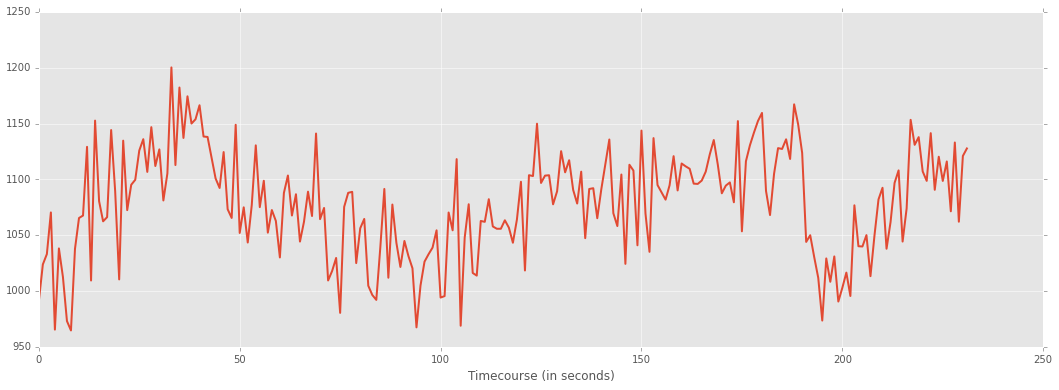

In [337]:
cur_vols = load_database('CO','imgVal')
cur_vols

cond_info = load_conditions(cur_vols.iloc[0])
cur_vols['volume_data'] = cur_vols.apply(lambda row: load_data(row), axis=1)
cur_vols['condition_info'] = cur_vols.apply(lambda row: load_conditions(row), axis=1)
plot_voxel(cur_vols)
for i in cur_vols.working_vol:
    print i
cur_vols


#running one run

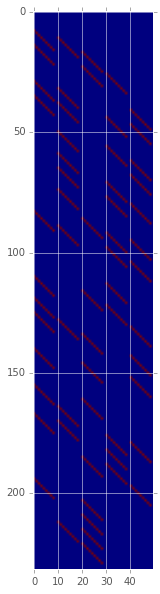

In [179]:
cond_seq = cur_vols['condition_info'].iloc[0][1]
cond_ons = cur_vols['condition_info'].iloc[0][2]
n_scans = cur_vols['nvols'].iloc[0]
TR = cur_vols['TR'].iloc[0]

des_mat, basis = he.create_design_matrix(cond_seq,cond_ons,TR = float(2),n_scans=n_scans, basis = 'fir',hrf_length=20,oversample=1)
plt.figure(figsize=(10,10))
plt.imshow(des_mat)

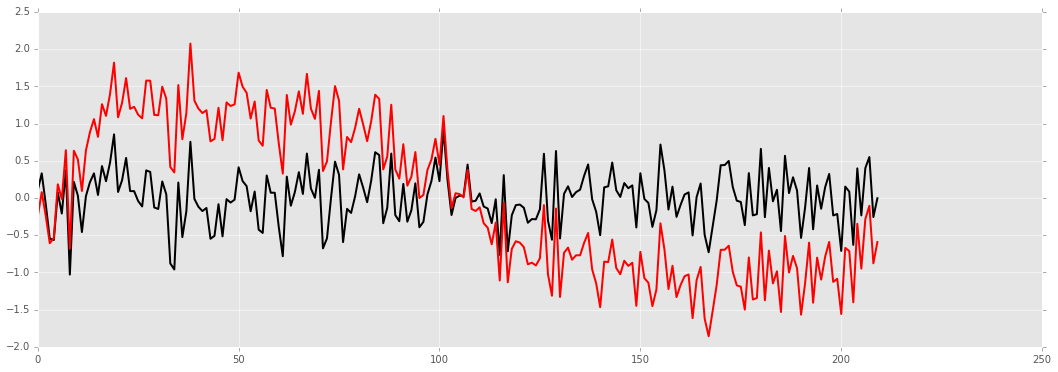

In [180]:
detrended_time_course = do_detrend(time_course)

plt.figure(figsize=(18, 6))
plt.plot(detrended_time_course, 'k', lw=2)
zt = time_course-time_course.mean(axis=0)
plt.plot(zt / zt.std(), 'r', lw=2)
plt.show()

In [198]:
##load a volume and reformat it into a voxels x time matrix -- check to make sure this is working!!
which_run = 0
voxels = load_data(cur_vols.iloc[which_run])
n_voxels = np.prod(voxels.shape[0:3])
n_scans = cur_vols['nvols'].iloc[which_run]
TR = float(cur_vols['TR'].iloc[which_run])
print 'TR : {}'.format(TR)
print 'n_voxels : {}'.format(n_voxels)
print 'n_scans : {}'.format(n_scans)

voxels = voxels.get_data().reshape((n_voxels,n_scans))
mask = load_mask(cur_vols.iloc[which_run]).get_data()
mask = mask.reshape((n_voxels,1))

print 'mask.shape : {}'.format(mask.shape)
print 'voxels.shape : {}'.format(voxels.shape)


sig_rows = []
# applying brain mask and detrending
for i in xrange(voxels.shape[0]):
    if mask[i] != 0 and max(voxels[i,:]) != 0:
#         sig_rows.append(  voxels[i,:] ) 
        sig_rows.append( do_detrend( voxels[i,:] ) )

    elif max(voxels[i,:]) == 0 and mask[i] != 0:
             mask[i] = 0
    if i % 50000 == 0:
        print '{} voxels prossessed'.format(i)
        print '{} useful voxels found'.format(len(sig_rows))



TR : 2.0
n_voxels : 454896
n_scans : 232
mask.shape : (454896, 1)
voxels.shape : (454896, 232)
0 voxels prossessed
0 useful voxels found
50000 voxels prossessed
0 useful voxels found
100000 voxels prossessed
7736 useful voxels found
150000 voxels prossessed
26770 useful voxels found
200000 voxels prossessed
51245 useful voxels found
250000 voxels prossessed
75497 useful voxels found
300000 voxels prossessed
98869 useful voxels found
350000 voxels prossessed
116127 useful voxels found
400000 voxels prossessed
121874 useful voxels found
450000 voxels prossessed
121874 useful voxels found


In [199]:
mask_count_nzeros = np.count_nonzero(mask)
mask_count = len(mask)
sig_count =  len(sig_rows)

if mask_count_nzeros != sig_count:
    warnings.warn('PROBLEM WITH MASK')
    print 'mask_count {} \n sig_count {}'.format(mask_count,sig_count)
if mask_count != n_voxels:
    warnings.warn('mask size is not equal to vol size')
if mask_count - mask_count_nzeros + sig_count != n_voxels:
    warnings.warm('PROBLEM 3 WITH MASK')
sig_rows = np.array(sig_rows)

In [207]:
##load the conditions information
cond_seq = cur_vols['condition_info'].iloc[which_run][1]
cond_ons = cur_vols['condition_info'].iloc[which_run][2]
#drifts = np.ones((sig_rows.T.shape[0], 1))


print sig_rows.shape

!ls

(121874, 232)


In [212]:
_time = default_timer()

flexi_hrfs, flexi_betas = he.glm(cond_seq, cond_ons, TR, sig_rows.T, mode='r1glm', basis='fir', verbose=1,n_jobs=-1)

print 'finished in {}h'.format((default_timer() - _time)/60)

.. creating design matrix ..
.. done creating design matrix ..
.. computing initialization ..
.. done initialization ..
(10, 121874)
(5, 121874)
.. completed 500 out of 15235 ..
.. completed 500 out of 15234 ..
.. completed 500 out of 15235 ..
.. completed 500 out of 15234 ..
.. completed 500 out of 15234 ..
.. completed 500 out of 15234 ..
.. completed 500 out of 15234 ..
.. completed 500 out of 15234 ..
.. completed 1000 out of 15235 .... completed 1000 out of 15234 .... completed 1000 out of 15235 .... completed 1000 out of 15234 .... completed 1000 out of 15234 .... completed 1000 out of 15234 .... completed 1000 out of 15234 .... completed 1000 out of 15234 ..







.. completed 1500 out of 15235 .... completed 1500 out of 15234 .... completed 1500 out of 15235 .... completed 1500 out of 15234 .... completed 1500 out of 15234 .... completed 1500 out of 15234 .... completed 1500 out of 15234 .... completed 1500 out of 15234 ..







.. completed 2000 out of 15235 .... completed 2

In [185]:
# import pickle

# fh ='/home/nick/Desktop/CO_dataset/3hrf.hrfs.pickle'
# fb ='/home/nick/Desktop/CO_dataset/3hrf.betas.pickle'

# if input('really???') == 'yes':
#     with open(fh, 'wb') as handle:
#         pickle.dump(hrfs, handle)
#     with open(fb, 'wb') as handle:
#         pickle.dump(betas, handle)




In [186]:
# import pickle

# fh ='/home/nick/Desktop/CO_dataset/3hrf.hrfs.pickle'
# fb ='/home/nick/Desktop/CO_dataset/3hrf.betas.pickle'

# import os
# if os.path.isfile(fh):
#     hrfs = pickle.load(open(fh,'rb'))
#     betas = pickle.load(open(fb,'rb'))


In [213]:
xx = arange(0, 20,2) # range of values for time
# construct the final HRF by multiplying by its basis
generated_hrfs = hrfs[0] * he.hrf.spmt(xx)[:, None] + hrfs[1] * he.hrf.dspmt(xx)[:, None] + hrfs[2] * he.hrf.ddspmt(xx)[:, None]

(10, 121874)


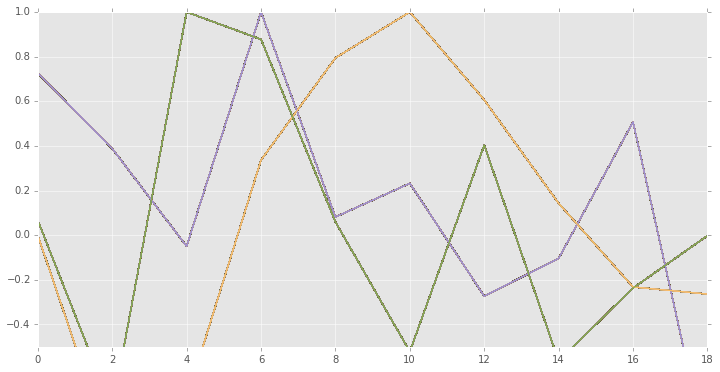

In [214]:
random_voxels = np.random.randint(0,high=hrfs.shape[0],size=1000)
plt.figure(figsize=(12, 6))
print flexi_hrfs.shape
plt.plot(xx, flexi_hrfs[:,random_voxels])
plt.ylim((-.5, 1.))
plt.show()

In [219]:
x = np.ceil(des_mat.T[::10]).T

r_hats = []
rsquares = []
from scipy.signal import convolve2d
# building estimated signal
for i in xrange(len(sig_rows)):
    h_e = flexi_hrfs[:,i]
    b = flexi_betas[:,i]
    h_e = h_e.reshape((len(h_e),1))
    xh = convolve2d(x,h_e)
    r_hats.append(np.dot(xh,np.reshape(b,len(b),1))[:n_scans])
print 'done with estimates'
for i in xrange(len(sig_rows)):
    r = sig_rows[i]
    r_hat = r_hats[i] 
    r_bar = np.mean(r)
    s1 = np.sum( [ (r[j] - r_hat[j] ) ** 2 for j in xrange(len(r))])
    s2 = np.sum( [ (r[k] - r_bar    ) ** 2 for k in xrange(len(r))])
    rsq = ( 1 - s1 / s2) * 100
#     print 'voxel {} R^2 = {}'.format(i,rsq)
    rsquares.append(rsq)
    


In [270]:
rsquares_sort = sorted(rsquares)[::-1]
for i in range(1000):
    print rsquares_sort[i]


43.9677262936
43.6639828458
42.1475007401
40.8957106909
40.4625537099
40.2999962094
40.158705606
40.1569700365
40.1405938903
39.8835050007
39.4733914305
39.2184706649
39.1757884287
39.14286145
39.0409669058
38.9153262271
38.8245358872
38.5866383765
38.3226707079
38.0112169176
37.9536470989
37.7843958816
37.7827052187
37.4569070631
37.3732984648
37.3722915346
37.1171104375
37.0829924829
36.9068663541
36.7299923744
36.5254787
36.5088609734
36.4363303013
36.2905226577
36.1365572694
36.1134029028
36.0610130525
36.0533045361
35.9889436428
35.9646560634
35.948806282
35.8977466464
35.8630427724
35.8412074837
35.7418677807
35.7298494132
35.6802540957
35.6270406018
35.560394111
35.5463042843
35.4155455978
35.2881118057
35.2816371532
35.1818788358
35.0292825653
34.9535956712
34.8900222098
34.790171819
34.745173619
34.6794345232
34.6413526586
34.6274570508
34.5440546143
34.4909260197
34.4133181783
34.3800759913
34.3351397728
34.2450388111
34.1568612908
34.0740127637
33.9791747203
33.9766056282
33

In [230]:
r = rsquares[:]

print mask.shape[0]
r_to_image = np.zeros((mask.shape[0],1))
print r_to_image.shape[0]
print len(r)
for i in xrange(mask.shape[0]):
    if mask[i] != 0:
        if len(r) > 0:
             r_to_image[i] = r.pop(0)
r_to_image =r_to_image.reshape((108,108,39))
        
img = nib.Nifti1Image(r_to_image ,np.eye(4))
nib.save(img,'/home/nick/Desktop/3hrf_test.nii')



454896
454896
121874


<matplotlib.colorbar.Colorbar instance at 0x7f667b1b3cb0>

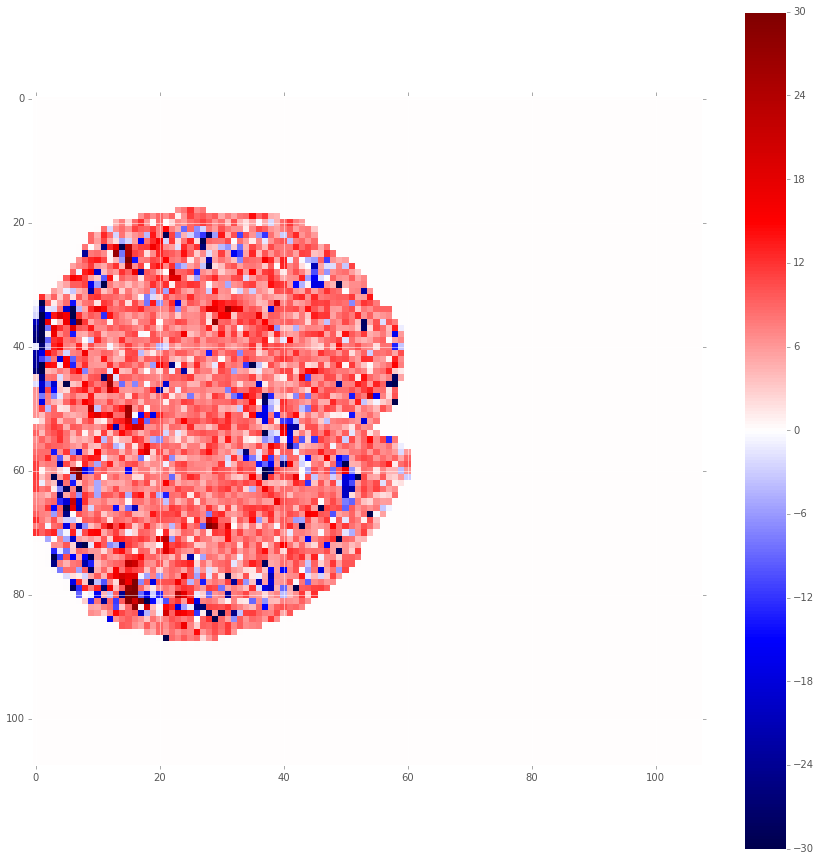

In [267]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,15

p = imshow(r_to_image[:,:,20],interpolation='none',vmin=-30,vmax=30)
p.set_cmap('seismic')
colorbar()


(108, 108)
15-20 : 2260
20-25 : 622
25-35 : 396
35+ : 55


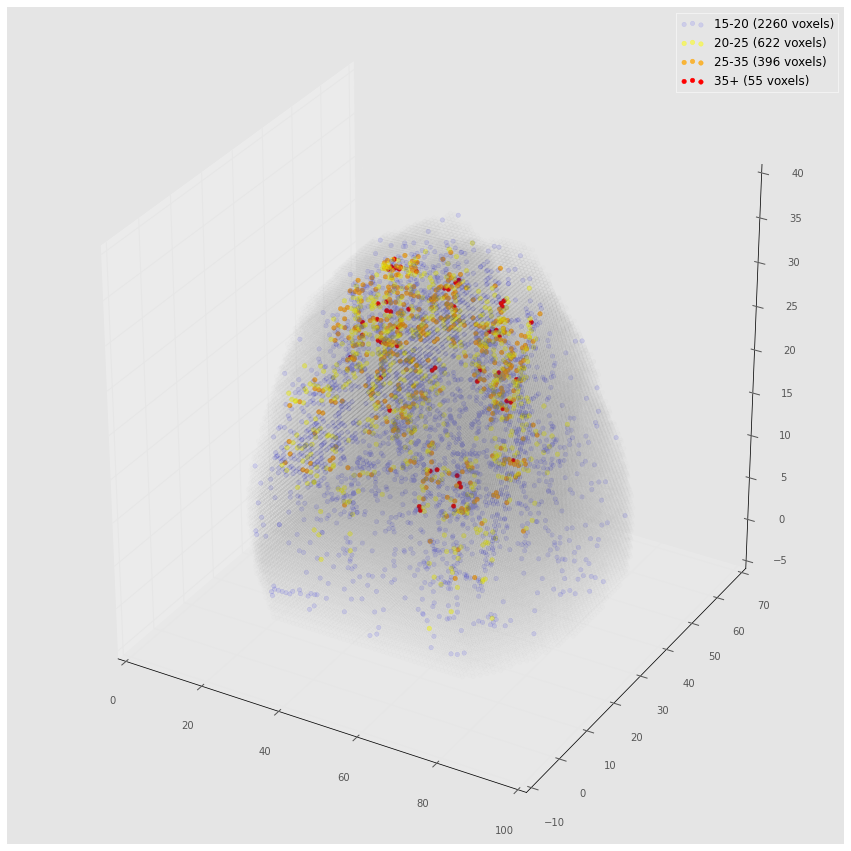

In [368]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

data = r_to_image[:,:,20]
print data.shape

# data[data == 0] = numpy.nan

x2535,y2535,z2535 = [],[],[]
x35,y35,z35 = [],[],[]
x2015,y2015,z2015 = [],[],[]
xa,ya,za = [],[],[]
x2520,y2520,z2520 = [],[],[]

mask = load_mask(cur_vols.iloc[which_run]).get_data()

for x in xrange(r_to_image.shape[0]):
    for y in xrange(r_to_image.shape[1]):
        for z in xrange(r_to_image.shape[2]):
            if mask[x,y,z] != 0:
                xa.append(x)
                ya.append(y)
                za.append(z)
            if 20 > r_to_image[x,y,z] > 15:
                x2015.append(x)
                y2015.append(y)
                z2015.append(z)
            if 25 > r_to_image[x,y,z] > 20:
                x2520.append(x)
                y2520.append(y)
                z2520.append(z)
            if 35 > r_to_image[x,y,z] > 25:
                x2535.append(x)
                y2535.append(y)
                z2535.append(z)
            if  r_to_image[x,y,z] > 35:
                x35.append(x)
                y35.append(y)
                z35.append(z)

xx = np.array(xx)
yy = np.array(yy)
zz = np.array(zz)

print '15-20 : {}'.format(len(x2015))
print '20-25 : {}'.format(len(x2520))
print '25-35 : {}'.format(len(x2535))
print '35+ : {}'.format(len(x35))


# create the figure
fig = plt.figure()

# show the reference image
# ax1.imshow(data, cmap='seismic', interpolation='nearest', origin='lower', extent=[0,1,0,1])

# show the 3D rotated projection
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(xa,ya,za,alpha=.015,color='grey')

ax2.scatter(x2015,y2015,z2015,color='blue',alpha=.1,label='15-20 ({} voxels)'.format(len(x2015)))
ax2.scatter(x2520,y2520,z2520,color='yellow',alpha=.5,label='20-25 ({} voxels)'.format(len(x2520)))
ax2.scatter(x2535,y2535,z2535,color='orange',alpha=.75,label='25-35 ({} voxels)'.format(len(x2535)))
ax2.scatter(x35,y35,z35,color='red',alpha=1,label='35+ ({} voxels)'.format(len(x35)))

ax2.legend()

# ax2.plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=plt.cm.seismic( r_to_image[:,:,21]), shade=False)

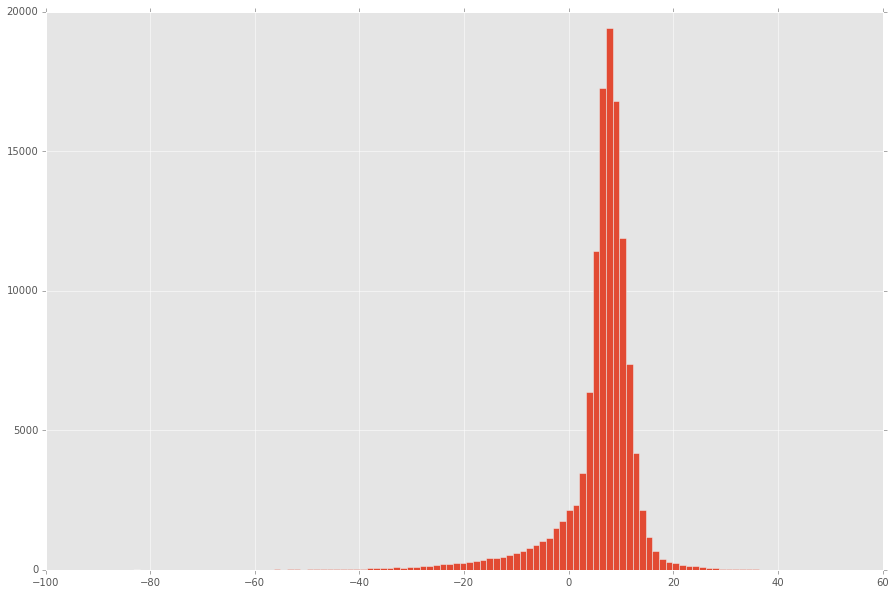

In [396]:
hist_data = rsquares
# hist_data[np.isnan(hist_data)] = 0
rcParams['figure.figsize'] = 15,10
x = hist(hist_data,bins=100,label='r-squared')